# Sampling CoCo image dataset to train and use DPM on

In [47]:
import json
import random
from pycocotools.coco import COCO
import requests
import os
import shutil
from tqdm import tqdm

from xml.etree.ElementTree import Element, SubElement, ElementTree, tostring 
from xml.dom.minidom import parseString 

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

We clear the folders beforehand

In [2]:
def clear_folder(folder_path):
    """
    Clears all files and subdirectories in the specified folder.

    Args:
        folder_path (str): Path to the folder to clear.
    """
    if os.path.exists(folder_path):
        # Remove all contents of the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file or symbolic link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove directory
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        # If folder doesn't exist, create it
        os.makedirs(folder_path)


Helper function to make PASCAL VOC-style XML annotations.

In [3]:
# Function to create Pascal-style XML annotations
def create_pascal_xml(img_info, annotations, output_annotation_dir, categories):
    """
    Generates a Pascal VOC-style XML file for a given image and its annotations.

    Args:
    - img_info (dict): Image metadata from COCO.
    - annotations (list): List of annotations for the image.
    - output_annotation_dir (str): Directory to save the XML file.
    - categories (list): List of category names to include in the annotations.
    """
    from xml.etree.ElementTree import Element, SubElement, tostring
    from xml.dom.minidom import parseString
    import os

    xml_root = Element('annotation')
    folder = SubElement(xml_root, 'folder')
    folder.text = 'VOC2007'

    filename = SubElement(xml_root, 'filename')
    filename.text = img_info['file_name']

    # default source
    source = SubElement(xml_root, 'source')
    database = SubElement(source, 'database')
    database.text = 'COCO Database'

    image = SubElement(source, 'image')
    image.text = 'flickr'

    annotation_tag = SubElement(source, 'annotation')
    annotation_tag.text = 'PASCAL VOC2007'

    flicker_id = SubElement(source, 'flickerid')
    flicker_id.text = '341012865'

    # default owner
    owner = SubElement(xml_root, 'owner')
    flicker_id = SubElement(owner, 'flickerid')
    flicker_id.text = 'Default owner'
    owner_name = SubElement(owner, 'name')
    owner_name.text = 'Default ownername'

    size = SubElement(xml_root, 'size')
    SubElement(size, 'width').text = str(img_info['width'])
    SubElement(size, 'height').text = str(img_info['height'])
    SubElement(size, 'depth').text = '3'  # Assuming RGB images

    segmented = SubElement(xml_root, 'segmented')
    segmented.text = '0'

    for ann in annotations:
        # Include only objects in the specified categories
        cat_id = ann['category_id']
        if cat_id not in id_categories.keys():
            continue

        obj = SubElement(xml_root, 'object')
        name = SubElement(obj, 'name')
        cat_name = id_categories[cat_id]
        name.text = cat_name  # Category name from COCO annotation

        # Default difficulty 0
        difficult = SubElement(obj, 'difficult')
        difficult.text = '0'
        
        # Default pose and truncated values
        pose = SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = SubElement(obj, 'truncated')
        bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
        x_min = bbox[0]
        y_min = bbox[1]
        x_max = bbox[0] + bbox[2]
        y_max = bbox[1] + bbox[3]
        is_truncated = (
            x_min < 0 or y_min < 0 or x_max > img_info['width'] or y_max > img_info['height']
        )
        truncated.text = '1' if is_truncated else '0'

        # Bounding box
        bndbox = SubElement(obj, 'bndbox')
        SubElement(bndbox, 'xmin').text = str(max(0, int(x_min)))  # Clip to image boundaries
        SubElement(bndbox, 'ymin').text = str(max(0, int(y_min)))
        SubElement(bndbox, 'xmax').text = str(min(img_info['width'], int(x_max)))
        SubElement(bndbox, 'ymax').text = str(min(img_info['height'], int(y_max)))

    # If no relevant annotations, skip saving the XML
    if not any(cat_name in categories for ann in annotations):
        print(f"Skipping XML generation for {img_info['file_name']} - no relevant annotations.")
        return

    # Pretty format 
    asstring = tostring(xml_root, 'utf-8')
    parsed_xml = parseString(asstring)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")

    # Remove the XML declaration manually
    pretty_xml = '\n'.join(pretty_xml.splitlines()[1:])

    # Save XML
    output_file = os.path.join(output_annotation_dir, f"{os.path.splitext(img_info['file_name'])[0]}.xml")
    with open(output_file, 'w') as f:
        f.write(pretty_xml)


In [4]:
# downloading 2000 images of training data for category person
# Paths
keypoints_annotation_file = 'annotations/person_keypoints_train2017.json'  # Update with your COCO annotation file path
annotation_file = 'annotations/instances_train2017.json'  # Update with your COCO annotation file path
output_dir = '/Users/junitasirait/Documents/princetoncourses/cos429/project/COCO_VOCdevkit/VOC2007'  # Folder to save downloaded images
annotations_dir = os.path.join(output_dir, 'Annotations')
sets_dir = os.path.join(output_dir, 'ImageSets', 'Main')
images_dir = os.path.join(output_dir, 'JPEGImages')
# os.makedirs(output_dir, exist_ok=True)

# Number of images to sample
num_images = 10

In [5]:
# Load COCO annotations
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=12.26s)
creating index...
index created!


In [11]:
categories = [
    'airplane', 
    'bicycle', 
    'bird', 
    'boat', 
    'bottle', 
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'dining table',
    'dog', 
    'horse', 
    'motorcycle', 
    'person', 
    'potted plant',
    'sheep',
    'couch',
    'train', 
    'TV',
]

In [71]:
category_ids = {cat['name']: cat['id'] for cat in coco.loadCats(coco.getCatIds()) if cat['name'] in categories}
id_categories = {v:k for (k,v) in category_ids.items()}
# category_ids
len(category_ids)

19

In [80]:
# Sampling for non-person categories
num_images_per_category = 300
person_instance_target = 5000

## Clean all

In [81]:
# To freshly download (erase existing data) 
clear_folder(annotations_dir)
clear_folder(sets_dir)
clear_folder(images_dir)

## Sampling

Sampling from CoCo dataset to form person and non-person data of similar size as Pascal. 

In [82]:
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

all_images = set()
# Track globally selected image IDs to avoid duplicates
globally_selected_image_ids = set()
random.seed(429)

# Prepare data structures
# train_txt_path = os.path.join(sets_dir, "train.txt")
# category_txt_files = {category: open(os.path.join(sets_dir, f"{category}_train.txt"), "w") for category in categories}
positive_samples = {category: set() for category in categories}
annotations_by_image = {}

# Prepare split-specific data structures
splits = {
    "train": {"image_ids": set(), "annotations": {}, "images": set()},
    "val": {"image_ids": set(), "annotations": {}, "images": set()},
    "test": {"image_ids": set(), "annotations": {}, "images": set()},
    "trainval": {"image_ids": set(), "annotations": {}, "images": set()}
}

# Initialize global variables
all_images = set()  # To track downloaded images
globally_selected_image_ids = set()  # Track globally selected image IDs
random.seed(429)  # Ensure reproducibility

# Ensure image directory exists
os.makedirs(images_dir, exist_ok=True)

# Process each category
for category, category_id in tqdm(category_ids.items(), desc="Processing categories"):
    print(f"Processing category: {category}")
    
    # Handle 'person' category separately
    if category == 'person':
        instance_target = person_instance_target
        instance_count = 0
        selected_image_ids = []
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)

        # Collect images until the instance target is reached
        for img_id in image_ids:
            print(f"Person count now: {instance_count}")
            if img_id in globally_selected_image_ids:
                continue
            ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[category_id])
            person_count = len(ann_ids)
            if instance_count + person_count <= instance_target:
                selected_image_ids.append(img_id)
                globally_selected_image_ids.add(img_id)
                instance_count += person_count
            else:
                break
        print(f"Selected {len(selected_image_ids)} images to meet {instance_count} 'person' instances.")
    else:
        # Default behavior for other categories
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)
        selected_image_ids = []
        for img_id in image_ids:
            if img_id in globally_selected_image_ids:
                continue
            selected_image_ids.append(img_id)
            globally_selected_image_ids.add(img_id)
            if len(selected_image_ids) >= num_images_per_category:
                break
    print(f"Selected {len(selected_image_ids)} unique images for category {category}.")

    # Split selected images into train, val, and test
    random.shuffle(selected_image_ids)
    num_images = len(selected_image_ids)
    train_end = int(num_images * train_ratio)
    val_end = train_end + int(num_images * val_ratio)
    print(f"num_immages: {num_images}, train_end: {train_end}, val_end: {val_end}")

    splits["train"]["image_ids"].update(selected_image_ids[:train_end])
    splits["val"]["image_ids"].update(selected_image_ids[train_end:val_end])
    splits["test"]["image_ids"].update(selected_image_ids[val_end:])

    # Collect annotations and positive samples
    for split in ["train", "val", "test"]:
        for img_id in splits[split]["image_ids"]:
            annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            splits[split]["annotations"][img_id] = annotations
            splits[split]["images"].add(
                os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
            )
            # Update positive samples
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id in id_categories.keys():
                    positive_samples[id_categories[cat_id]].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )

# Create trainval split (combine train and val)
splits["trainval"]["image_ids"] = splits["train"]["image_ids"].union(splits["val"]["image_ids"])
splits["trainval"]["annotations"] = {**splits["train"]["annotations"], **splits["val"]["annotations"]}
splits["trainval"]["images"] = splits["train"]["images"].union(splits["val"]["images"])

# Download images and create XML annotations for each split
for split, data in splits.items():
    for img_id, annotations in tqdm(data["annotations"].items(), desc=f"Processing {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = os.path.splitext(img_info['file_name'])[0]
        img_filepath = os.path.join(images_dir, img_info['file_name'])

        # Download the image if not already downloaded
        if img_filename not in all_images:
            if not os.path.exists(img_filepath):
                try:
                    response = requests.get(img_info['coco_url'], stream=True, timeout=10)
                    response.raise_for_status()
                    with open(img_filepath, 'wb') as f:
                        for chunk in response.iter_content(1024):
                            f.write(chunk)
                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {img_info['file_name']}: {e}")
                    continue  # Skip this image on failure

            all_images.add(img_filename)

        # Generate XML annotation
        create_pascal_xml(img_info, annotations, annotations_dir, categories)

# Write ImageSets files for each split
for split, data in splits.items():
    txt_path = os.path.join(sets_dir, f"{split}.txt")
    with open(txt_path, "w") as file:
        for img_filename in sorted(data["images"]):
            file.write(f"{img_filename}\n")

    # Write category-specific files
    for category in categories:
        category_txt_path = os.path.join(sets_dir, f"{category}_{split}.txt")
        with open(category_txt_path, "w") as category_file:
            for img_filename in sorted(data["images"]):
                label = "1" if img_filename in positive_samples[category] else "-1"
                category_file.write(f"{img_filename} {label}\n")

print(f"ImageSets for train, val, test, and trainval created at {sets_dir}.")


Processing categories:   5%|██▋                                                | 1/19 [00:00<00:08,  2.23it/s]

Processing category: person
Person count now: 0
Person count now: 2
Person count now: 3
Person count now: 6
Person count now: 9
Person count now: 10
Person count now: 14
Person count now: 20
Person count now: 21
Person count now: 22
Person count now: 26
Person count now: 34
Person count now: 39
Person count now: 41
Person count now: 46
Person count now: 55
Person count now: 56
Person count now: 69
Person count now: 71
Person count now: 77
Person count now: 83
Person count now: 86
Person count now: 88
Person count now: 102
Person count now: 110
Person count now: 112
Person count now: 113
Person count now: 114
Person count now: 116
Person count now: 117
Person count now: 119
Person count now: 120
Person count now: 134
Person count now: 148
Person count now: 161
Person count now: 171
Person count now: 181
Person count now: 184
Person count now: 185
Person count now: 186
Person count now: 197
Person count now: 203
Person count now: 204
Person count now: 206
Person count now: 210
Person cou

Processing categories:  26%|█████████████▍                                     | 5/19 [00:00<00:01,  8.89it/s]

Processing category: motorcycle
Selected 300 unique images for category motorcycle.
num_immages: 300, train_end: 210, val_end: 255
Processing category: airplane
Selected 300 unique images for category airplane.
num_immages: 300, train_end: 210, val_end: 255
Processing category: bus
Selected 300 unique images for category bus.
num_immages: 300, train_end: 210, val_end: 255
Processing category: train
Selected 300 unique images for category train.
num_immages: 300, train_end: 210, val_end: 255


Processing categories:  47%|████████████████████████▏                          | 9/19 [00:01<00:01,  9.97it/s]

Processing category: boat
Selected 300 unique images for category boat.
num_immages: 300, train_end: 210, val_end: 255
Processing category: bird
Selected 300 unique images for category bird.
num_immages: 300, train_end: 210, val_end: 255
Processing category: cat
Selected 300 unique images for category cat.
num_immages: 300, train_end: 210, val_end: 255


Processing categories:  58%|████████████████████████████▉                     | 11/19 [00:01<00:00,  9.85it/s]

Processing category: dog
Selected 300 unique images for category dog.
num_immages: 300, train_end: 210, val_end: 255
Processing category: horse
Selected 300 unique images for category horse.
num_immages: 300, train_end: 210, val_end: 255


Processing categories:  68%|██████████████████████████████████▏               | 13/19 [00:01<00:00,  9.42it/s]

Processing category: sheep
Selected 300 unique images for category sheep.
num_immages: 300, train_end: 210, val_end: 255
Processing category: cow
Selected 300 unique images for category cow.
num_immages: 300, train_end: 210, val_end: 255


Processing categories:  79%|███████████████████████████████████████▍          | 15/19 [00:01<00:00,  8.44it/s]

Processing category: bottle
Selected 300 unique images for category bottle.
num_immages: 300, train_end: 210, val_end: 255
Processing category: chair
Selected 300 unique images for category chair.
num_immages: 300, train_end: 210, val_end: 255


Processing categories:  89%|████████████████████████████████████████████▋     | 17/19 [00:02<00:00,  7.33it/s]

Processing category: couch
Selected 300 unique images for category couch.
num_immages: 300, train_end: 210, val_end: 255
Processing category: potted plant
Selected 300 unique images for category potted plant.
num_immages: 300, train_end: 210, val_end: 255


Processing categories: 100%|██████████████████████████████████████████████████| 19/19 [00:02<00:00,  7.70it/s]


Processing category: dining table
Selected 300 unique images for category dining table.
num_immages: 300, train_end: 210, val_end: 255


Processing trainval images: 100%|████████████████████████████████████████| 5610/5610 [00:07<00:00, 723.37it/s]


ImageSets for train, val, test, and trainval created at /Users/junitasirait/Documents/princetoncourses/cos429/project/COCO_VOCdevkit/VOC2007/ImageSets/Main.


## Sampling for parts

In [6]:
coco = COCO(keypoints_annotation_file)

loading annotations into memory...
Done (t=7.45s)
creating index...
index created!


In [7]:
help(coco)

Help on COCO in module pycocotools.coco object:

class COCO(builtins.object)
 |  COCO(annotation_file=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, annotation_file=None)
 |      Constructor of Microsoft COCO helper class for reading and visualizing annotations.
 |      :param annotation_file (str): location of annotation file
 |      :param image_folder (str): location to the folder that hosts images.
 |      :return:
 |  
 |  annToMask(self, ann)
 |      Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
 |      :return: binary mask (numpy 2D array)
 |  
 |  annToRLE(self, ann)
 |      Convert annotation which can be polygons, uncompressed RLE to RLE.
 |      :return: binary mask (numpy 2D array)
 |  
 |  createIndex(self)
 |  
 |  download(self, tarDir=None, imgIds=[])
 |      Download COCO images from mscoco.org server.
 |      :param tarDir (str): COCO results directory name
 |             imgIds (list): images to be downloaded
 |     

In [15]:
coco.getCatIds(catNms=[c for c in categories])

[1]

idcs_to_show: [51, 52, 53]
image id: 579267


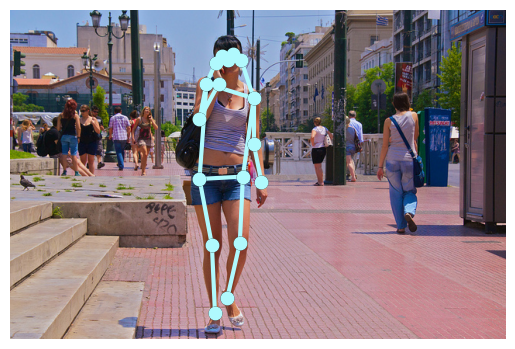

In [310]:
# random.seed(429)
person_sample = random.sample(sorted(coco.getImgIds(catIds=[1])), 1)[0]
person_sample = 579267  # 168215, 26817, 178557, 345100, 115146, 555537, 431555, 245415
person_sample

# Let's select one image to visualize
img_id = person_sample
annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=[1])
annotation_id = annotation_ids[0]
len(annotation_ids), annotation_ids[0]

loaded_annotations = coco.loadAnns(ids=annotation_ids)
len(loaded_annotations)

# download image 
image_info = coco.loadImgs(img_id)[0]
response = requests.get(image_info['coco_url'])
image = Image.open(BytesIO(response.content))

# let's visualize the keypoints one by one 
kp_vis = 17
idcs_to_show = [kp_vis*3, kp_vis*3+1, kp_vis*3+2]
print(f"idcs_to_show: {idcs_to_show}")
kp_mask = [1 if i in idcs_to_show else 0 for i in range(51)]
original_keypoints = loaded_annotations[0]['keypoints']
kps = [original_keypoints[i] if kp_mask[i] else 0 for i in range(51)]

original_annotation = {
    # 'keypoints': kps, 
    'keypoints': original_keypoints, 
    'category_id': 1,
}

print(f"image id: {person_sample}")
plt.imshow(image)
plt.axis('off')
coco.showAnns([original_annotation], draw_bbox=False)

# according to 206431 need to also consider shoulders most likely
# silly examples: 369872, 178166, 567671

In [232]:
loaded_annotations[0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [82]:
# looking at length of keypoints 
[len(a['keypoints']) for a in loaded_annotations]

# so we know that this length is always 51 -- if a keypoint does not exist then it is represented as 0,0,0

[51, 51]

In [309]:
# Keypoints
kpd = {
    0: 'nose', 
    1: 'left_eye', 
    2: 'right_eye', 
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder', 
    7: 'left_elbow', 
    8: 'right_elbow', 
    9: 'left_wrist', 
    10: 'right_wrist', 
    11: 'left_hip', 
    12: 'right_hip', 
    13: 'left_knee', 
    14: 'right_knee', 
    15: 'left_ankle', 
    16: 'right_ankle', 
}


In [ ]:
# Part 1: Head. Keypoints: 0, 5, 6.
# Part 2: Torso. Keypoints: 5, 6, 11, 12. 
# Part 3: Lower arm. Keypoints: 7/8, 9/10, with pad half the length (
# Part 4: Lower legs. Keypoints: 13/14, 15/16, with pad half the length. 

### Playground

In [42]:
coco.loadImgs(ids=[10948])

[{'license': 6,
  'file_name': '000000010948.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000010948.jpg',
  'height': 376,
  'width': 500,
  'date_captured': '2013-11-22 00:28:09',
  'flickr_url': 'http://farm1.staticflickr.com/121/305482790_d063783500_z.jpg',
  'id': 10948}]

In [43]:
coco.getAnnIds(imgIds=[10948])

[47931,
 99444,
 200424,
 235251,
 1334779,
 1510594,
 1629956,
 1973648,
 1974781,
 1974896,
 1991653]

In [53]:
[a['category_id'] for a in coco.loadAnns([
     47931,
     99444,
     200424,
     235251,
     1334779,
     1510594,
     1629956,
     1973648,
     1974781,
     1974896,
     1991653
])]

[17, 63, 1, 1, 2, 47, 75, 75, 75, 75, 85]

In [45]:
category_ids

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'boat': 9,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'bottle': 44,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'dining table': 67}

In [60]:
coco.loadAnns(47931)

[{'segmentation': [[321.99,
    258.37,
    317.94,
    252.85,
    318.68,
    248.07,
    320.89,
    242.18,
    324.2,
    239.98,
    330.82,
    238.5,
    335.6,
    233.72,
    342.22,
    233.72,
    348.1,
    234.09,
    351.04,
    235.19,
    348.47,
    229.68,
    356.56,
    229.68,
    359.5,
    231.52,
    366.49,
    230.05,
    370.17,
    230.41,
    372.74,
    234.09,
    371.27,
    239.24,
    373.11,
    244.76,
    372.38,
    246.96,
    371.64,
    248.8,
    372.01,
    252.85,
    372.01,
    256.16,
    375.32,
    259.1,
    375.69,
    262.04,
    372.38,
    263.15,
    368.33,
    263.88,
    365.02,
    265.72,
    362.08,
    264.99,
    360.97,
    263.15,
    356.93,
    263.88,
    348.47,
    265.35,
    342.59,
    266.09,
    340.01,
    267.56,
    334.86,
    267.93,
    330.82,
    266.82,
    326.04,
    264.99,
    324.2,
    263.51,
    322.36,
    260.2,
    320.15,
    258.0]],
  'area': 1648.8485,
  'iscrowd': 0,
  'image_id': 10948